<a href="https://colab.research.google.com/github/Alexandre77777/data_mining/blob/main/2.%20%D0%9A%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_%E2%84%965_%D0%A1%D0%BE%D0%B7%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_%D0%BF%D1%80%D0%BE%D1%81%D1%82%D0%BE%D0%B9_%D1%80%D0%B5%D0%BA%D0%BE%D0%BC%D0%B5%D0%BD%D0%B4%D0%B0%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D0%BE%D0%B9_%D1%81%D0%B8%D1%81%D1%82%D0%B5%D0%BC%D1%8B_%D0%BD%D0%B0_%D0%BE%D1%81%D0%BD%D0%BE%D0%B2%D0%B5_%D0%B0%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC%D0%BE%D0%B2_%D0%BA%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Практическая работа №5. Создание простой рекомендательной системы на основе алгоритмов кластеризации

На основе оценок аниме, которые ставят пользователи систем типа [MAL](https://myanimelist.net/), можно строить разные кластеры данных:
- кластеры похожих людей. Похожие значит, что эти люди ставят похожие рейтинги аниме.
- кластеры похожих аниме. Похожие значит что люди оценивают их похоже.
- кластеры похожих жанров. Но похожие не в обычном смысле, а в смысле, что люди которые смотрят жанр А любят смотреть жанр Б.

и т.д.

### Полезная литература

- [Лекция 8. Рекомендательный системы](https://www.youtube.com/watch?v=Te_6TqEhyTI&t=4s).
- [Туториал по рекомендательным системам](http://nbviewer.jupyter.org/urls/gitlab.7bits.it/isiganov/ml-course/raw/master/week05/theory/05-01-clustering.ipynb?inline=false)
- [ODS: Обучение без учителя: PCA и кластеризация](https://habrahabr.ru/company/ods/blog/325654/)
- [Интересные алгоритмы кластеризации, часть первая: Affinity propagation](https://habrahabr.ru/post/321216/) и другие статьи цикла
- [Глава 7: кластеризация и визуализация. К. В. Воронцов](http://www.machinelearning.ru/wiki/images/6/6d/Voron-ML-1.pdf)
- [Документация sklearn.clustering](http://scikit-learn.org/stable/modules/clustering.html)
- [K-Means Clustering - The Math of Intelligence. Siraj Raval](https://www.youtube.com/watch?v=9991JlKnFmk) объяснение с программированием KMeans вручную



In [1]:
from sklearn import datasets
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans

from tqdm import tqdm
# from tqdm import tqdm_notebook as tqdm # Раскоментируйте если прогресс бар будет странно работать

%matplotlib inline

# Зафиксируем случайность, чтобы у нас получались одинаковые результаты.
np.random.seed(seed=42)

## Анализ отзывов аниме

Возьмем датасет с рейтингами аниме: https://www.kaggle.com/CooperUnion/anime-recommendations-database  
Кстати, вы можете посмотреть kernels - это jupyter notebooks, в которых другие люди тоже делали что-то с этим датасетом.

```
Anime.csv

anime_id - myanimelist.net's unique id identifying an anime.
name - full name of anime.
genre - comma separated list of genres for this anime.
type - movie, TV, OVA, etc.
episodes - how many episodes in this show. (1 if movie).
rating - average rating out of 10 for this anime.
members - number of community members that are in this anime's "group".


Rating.csv

user_id - non identifiable randomly generated user id.
anime_id - the anime that this user has rated.
rating - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).
```

In [2]:
colab = False  # True если используте google colab
if colab:
    from google.colab import drive
    drive.mount('/content/drive/')

In [3]:
if colab:
    anime = pd.read_csv('/content/drive/My Drive/Data/anime/anime.csv.zip', index_col='anime_id')
else:
    anime = pd.read_csv('../data/anime/anime.csv', index_col='anime_id')
anime.dropna(inplace=True)
print(anime.shape)
anime.head()

(12017, 6)


,name,genre,type,episodes,rating,members
anime_id,,,,,,
32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [4]:
if colab:
    ratings = pd.read_csv('/content/drive/My Drive/Data/anime/rating.csv.zip')
else:
    ratings = pd.read_csv('../data/anime/rating.csv')
ratings

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1
...,...,...,...
7813732,73515,16512,7
7813733,73515,17187,9
7813734,73515,22145,10
7813735,73516,790,9


Датасет очень большой и грязный. Некоторые действия с этим датасетом будут требовать много оперативной памяти(>6 Гб).

## Подготовка данных

Во первых, в датасете есть много -1. Оценки -1 и 0 на MAL нет.

Здесь -1 означает что человек посмотрел это аниме, но не выставил оценку.

Такие записи из `ratings` стоит выбросить, так как в нашем случае они особо не помогут.

Но и не помешают серьезно. Если хотите оставьте их, только нужно заменить все -1 на 0, так как дальше нам понадобится посчитать среднее, а -1 или 0, в отличие от `np.nan`, повлияют на среднее.

### 1. Избавьтесь от -1

In [5]:
ratings.drop(ratings[ratings['rating'] <= 0].index, inplace = True)
ratings

,user_id,anime_id,rating
47,1,8074,10
81,1,11617,10
83,1,11757,10
101,1,15451,10
153,2,11771,10
...,...,...,...
7813732,73515,16512,7
7813733,73515,17187,9
7813734,73515,22145,10
7813735,73516,790,9


## Критерий Шавене (Chauvenet)

$$ erfc(\frac{|P_i - mean(P)|}{S_p})  < \frac{1}{2n}$$

$ S_p - отклонение $

Готовой реализации в библиотеках нет, поэтому придется написать самим(но если найдете можете использовать).

### 2. Напишите функцию, которая принимает на вход массив, считает критерий Шавене и возвращает булеву маску.

Функция `erfc` есть в sklearn.

In [6]:
from scipy.special import erfc
import numpy as np

def chauvenet(array):
    n = len(array)
    stdv = np.std(array)
    mean = np.mean(array)
    c = 1.0 / (2*n)
    d = abs(array-mean)/stdv
    prob = erfc(d)
    return prob < c  

Для начала давайте посмотрим на таблицу рейтингов.

### 3. Сделайте новую таблицу `count_reviews` где индексами будет `user_id` а значением будет количество просмотренных им аниме.


**Hint** Используйте [groupby](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) и [count](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.count.html).

In [7]:
count_reviews = pd.DataFrame()
count_reviews["count_reviews"] = ratings.groupby(["user_id"]).count()['anime_id']
count_reviews.head()


,count_reviews
user_id,
1,4
2,1
3,92
5,459
7,343


### 4. Используйте функцию chauvenet и найдите все выбросы.

**Hint:** Так как chauvenet возвращает маску используйте оператор `[]` (подробнее смотрите в теории по pandas и numpy).

**Hint:** Используйте [values](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.values.html).

In [8]:
outlier_users = count_reviews[chauvenet(count_reviews['count_reviews']) == True]
outlier_users.describe()

,count_reviews
count,1216.000000
mean,764.294408
std,292.096067
min,522.000000
25%,582.000000
50%,675.000000
75%,839.000000
max,3747.000000


### 5. Ответьте на вопросы

#### Кого критерий посчитал выбросом?

#### Почему критерий посчитал их выбросом?

#### Нужна ли им вообще рекомендательная система?



**Ответы:**

1. Тех у кого очень много просмотров
1. Так как они значительно отклоняются по количеству просмотров от среднего
1. Скорей всего нет, ведь они уже все посмотрели или близки к этому

In [9]:
bad_user_threshold = outlier_users.min()
bad_user_threshold

count_reviews    522
dtype: int64

Если все было правильно `bad_user_threshold` больше 500.

Нужно выбросить всех людей у которых число просмотренных аниме больше или равно `bad_user_threshold`.

### 6. Переименнуйте столбец из таблицы `count_reviews` в `count_reviews` (он там единственный). Соедините `count_reviews` и `ratings` по столбцу `user_id`. И оставьте в `ratings` только тех кто посмотрел меньше `bad_user_threshold`  

In [10]:
ratings = pd.merge(ratings, count_reviews, on='user_id')
ratings.info()
ratings.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6337241 entries, 0 to 6337240
Data columns (total 4 columns):
 #   Column         Dtype
---  ------         -----
 0   user_id        int64
 1   anime_id       int64
 2   rating         int64
 3   count_reviews  int64
dtypes: int64(4)
memory usage: 241.7 MB


,user_id,anime_id,rating,count_reviews
0,1,8074,10,4
1,1,11617,10,4
2,1,11757,10,4
3,1,15451,10,4
4,2,11771,10,1


In [11]:
ratings.drop(ratings[ratings['count_reviews'] > bad_user_threshold[0]].index, inplace = True)
ratings.info()
ratings.tail()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5410991 entries, 0 to 6337240
Data columns (total 4 columns):
 #   Column         Dtype
---  ------         -----
 0   user_id        int64
 1   anime_id       int64
 2   rating         int64
 3   count_reviews  int64
dtypes: int64(4)
memory usage: 206.4 MB


,user_id,anime_id,rating,count_reviews
6337236,73515,16512,7,179
6337237,73515,17187,9,179
6337238,73515,22145,10,179
6337239,73516,790,9,2
6337240,73516,8074,9,2


Осталось все равно слишком много пользователей.

### 7. Удалите из таблицы всех юзеров, у которых количество просмотров меньше медианного значения. То есть мы удалим половину юзеров.

Так как они посмотрели слишком мало, чтобы мы на них могли основывать свои советы.

In [12]:
ratings.drop(ratings[ratings['count_reviews'] < ratings['count_reviews'].median()].index, inplace = True)
ratings

,user_id,anime_id,rating,count_reviews
97,5,6,8,459
98,5,15,6,459
99,5,17,6,459
100,5,18,6,459
101,5,20,6,459
...,...,...,...,...
6337234,73515,13659,8,179
6337235,73515,14345,7,179
6337236,73515,16512,7,179
6337237,73515,17187,9,179


In [13]:
ratings = ratings.drop(columns=['count_reviews'])
ratings

,user_id,anime_id,rating
97,5,6,8
98,5,15,6
99,5,17,6
100,5,18,6
101,5,20,6
...,...,...,...
6337234,73515,13659,8
6337235,73515,14345,7
6337236,73515,16512,7
6337237,73515,17187,9


Теперь рассмотрим таблицу `anime`.


Так же применим критерий шавене.

Искать выбросы стоит по столбцу `rating` или по `members` или по обоим сразу.

### 8. Используйте функцию chauvenet и найдите все выбросы среди аниме. И удалите их.

**Hint** Используйте [drop](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html) и [index](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.index.html)

In [14]:
anime.describe()

,rating,members
count,12017.000000,1.201700e+04
mean,6.478264,1.834888e+04
std,1.023857,5.537250e+04
min,1.670000,1.200000e+01
25%,5.890000,2.250000e+02
50%,6.570000,1.552000e+03
75%,7.180000,9.588000e+03
max,10.000000,1.013917e+06


In [15]:
rating_outlier_animes = anime[(chauvenet(anime['rating']) == True)]
rating_outlier_animes.describe()

,rating,members
count,92.00000,92.000000
mean,3.34587,736.684783
std,1.23307,3090.594302
min,1.67000,12.000000
25%,2.99500,60.750000
50%,3.28500,92.000000
75%,3.41000,144.750000
max,10.00000,27557.000000


In [16]:
members_outlier_animes = anime[(chauvenet(anime['members']) == True)]
members_outlier_animes.describe()


,rating,members
count,264.000000,2.640000e+02
mean,8.060152,3.131798e+05
std,0.482955,1.433473e+05
min,6.170000,1.788800e+05
25%,7.697500,2.134552e+05
50%,8.060000,2.625335e+05
75%,8.420000,3.566320e+05
max,9.370000,1.013917e+06


In [17]:
###  Ваш код  ###
outlier_anime = pd.concat([members_outlier_animes, rating_outlier_animes])
outlier_anime

,name,genre,type,episodes,rating,members
anime_id,,,,,,
32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
11061,Hunter x Hunter (2011),"Action, Adventure, Shounen, Super Power",TV,148,9.13,425855
4181,Clannad: After Story,"Drama, Fantasy, Romance, Slice of Life, Supern...",TV,24,9.06,456749
...,...,...,...,...,...,...
20007,Hi Gekiga Ukiyoe Senya Ichiya,"Action, Hentai",Movie,1,1.92,129
17825,Ikenai Boy: Ikasu Maruhi Hand Power,"Comedy, Hentai",OVA,1,3.11,112
23677,Manga Edo Erobanashi,"Comedy, Hentai, Historical",OVA,5,2.86,111


In [18]:
anime.drop(outlier_anime.index, inplace = True)
anime

,name,genre,type,episodes,rating,members
anime_id,,,,,,
28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports",TV,10,9.15,93351
820,Ginga Eiyuu Densetsu,"Drama, Military, Sci-Fi, Space",OVA,110,9.11,80679
15335,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...,"Action, Comedy, Historical, Parody, Samurai, S...",Movie,1,9.10,72534
...,...,...,...,...,...,...
9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
5543,Under World,Hentai,OVA,1,4.28,183
5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219


### 9. Ответье на вопросы

#### Что критерий посчитал выбросом?

#### Почему критерий посчитал их выбросом?

#### Можем ли мы как то использовать эти аниме в нашей рекомендательное системе?

**Ответы:**

1. Аномально высокие и низкие рэйтинги, а также количество просмотров превышающее 180000
1. Сильно отличаются от средних значений
1. Нет, их либо и так все видели, либо они имеют завышенный или заниженный рейтинг

## Кластеризация по жанрам

Данные о жанре хранятся как строка, разделенная запятой `,` . Но нам нужны сами жанры. Придется поколдовать и разделить эту строку на элементы.

In [19]:
from itertools import chain
'''
Нам нужна функция flatmap.
Flatmap получает на вход список, на каждом элементе вызывает функцию f, которая возвращает другой список.
В результате получается список списков. (flatten - уплощение списка списков в один список).
'''
def flatmap(f, items):
    return chain.from_iterable(map(f, items))

# пример использования
list(flatmap(lambda x: [0, x , x*x], [1,2,3,4,5]))
# Первый шаг: [[0, 1, 1], [0, 2, 4], [0, 3, 9], [0, 4, 16], [0, 5, 25]]

[0, 1, 1, 0, 2, 4, 0, 3, 9, 0, 4, 16, 0, 5, 25]

In [20]:
# создаем функцию, которая просто разбивает строку по символу ", " на подстроки
def genre_splitter(genre_names):
    return genre_names.split(", ")

m_uniq = anime['genre'].unique() # смотрим сколько всего уникальных комбинация genres есть в датасете
print("m_uniq[0:10] = {}\nlen= {}\n".format(m_uniq[0:10], len(m_uniq))) # как видим комбинаций очень много, так как там все композиции

genres = set(flatmap(genre_splitter, m_uniq)) # разбиваем все genres на составные части и генерируем один массив из всех жанров. Строим по массиву множество уникальных жанров

genres = list(genres) # множество превращаем в список
print("Genres={}\nlen={}".format(genres, len(genres)))

m_uniq[0:10] = ['Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen'
 'Comedy, Drama, School, Shounen, Sports' 'Drama, Military, Sci-Fi, Space'
 'Drama, School, Shounen'
 'Adventure, Fantasy, Historical, Mystery, Seinen, Slice of Life, Supernatural'
 'Comedy, Drama, Shounen, Sports'
 'Action, Drama, Historical, Martial Arts, Romance, Samurai'
 'Drama, Fantasy, Shoujo, Slice of Life, Supernatural'
 'Action, Mystery, Supernatural, Vampire'
 'Comedy, Drama, Romance, Shounen']
len= 3135

Genres=['Demons', 'Shounen', 'Harem', 'Music', 'Psychological', 'Seinen', 'Game', 'Sports', 'Parody', 'Mystery', 'Sci-Fi', 'Supernatural', 'Mecha', 'Horror', 'Shoujo Ai', 'Comedy', 'Fantasy', 'Romance', 'Police', 'School', 'Hentai', 'Ecchi', 'Magic', 'Adventure', 'Shoujo', 'Space', 'Dementia', 'Yaoi', 'Samurai', 'Josei', 'Cars', 'Historical', 'Vampire', 'Yuri', 'Action', 'Military', 'Drama', 'Thriller', 'Slice of Life', 'Super Power', 'Kids', 'Martial Arts', 'Shounen Ai']
len=43


### 10. Создадим новую таблицу, где в колонках будет жанр, в строках аниме, а в ячейках 1 если у фильма есть этот жанр и 0 в противном случае.

Такой формат таблиц называтеся one-hot-encoding. Только в нашем случае в каждой строке будет не одна единица, а несколько, так как у аниме как правило несолько жанров.

Уточнение: жанры должны быть индексами столбцов (columns), а id аниме - индексами строк (index)

In [21]:
anime['genre'].str.split(', ', expand=False)

anime_id
28977    [Action, Comedy, Historical, Parody, Samurai, ...
9969     [Action, Comedy, Historical, Parody, Samurai, ...
32935             [Comedy, Drama, School, Shounen, Sports]
820                       [Drama, Military, Sci-Fi, Space]
15335    [Action, Comedy, Historical, Parody, Samurai, ...
                               ...                        
9316                                              [Hentai]
5543                                              [Hentai]
5621                                              [Hentai]
6133                                              [Hentai]
26081                                             [Hentai]
Name: genre, Length: 11661, dtype: object

In [22]:
anime_with_genre = pd.DataFrame(anime['genre'].str.split(', ', expand=False))
anime_with_genre

,genre
anime_id,
28977,"[Action, Comedy, Historical, Parody, Samurai, ..."
9969,"[Action, Comedy, Historical, Parody, Samurai, ..."
32935,"[Comedy, Drama, School, Shounen, Sports]"
820,"[Drama, Military, Sci-Fi, Space]"
15335,"[Action, Comedy, Historical, Parody, Samurai, ..."
...,...
9316,[Hentai]
5543,[Hentai]
5621,[Hentai]


In [23]:

anime_genre = pd.DataFrame(index=anime.index, columns=genres)
anime_genre[:] = 0
anime_genre

,Demons,Shounen,Harem,Music,Psychological,Seinen,Game,Sports,Parody,Mystery,...,Yuri,Action,Military,Drama,Thriller,Slice of Life,Super Power,Kids,Martial Arts,Shounen Ai
anime_id,,,,,,,,,,,,,,,,,,,,,
28977,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9969,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32935,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
820,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15335,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9316,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5543,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5621,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
for index in anime_with_genre.index:
    anime_genres = anime_with_genre.loc[index, 'genre']
    for genre in anime_genres:
        anime_genre.at[index, genre] = 1


In [25]:
anime_genre

,Demons,Shounen,Harem,Music,Psychological,Seinen,Game,Sports,Parody,Mystery,...,Yuri,Action,Military,Drama,Thriller,Slice of Life,Super Power,Kids,Martial Arts,Shounen Ai
anime_id,,,,,,,,,,,,,,,,,,,,,
28977,0,1,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
9969,0,1,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
32935,0,1,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
820,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
15335,0,1,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9316,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5543,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5621,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Итак, у нас есть следующие таблицы:
- Жанры аниме - в строчках аниме, в столбцах жанр аниме, а в ячейках 0 или 1.
- Рейтинги - в строчках пользователи, в столбцах id аниме и рейтинг

Нужно получить другую таблицу, в которой в строках будут пользователи, а в столбцах жанры аниме. А в ячейках средняя оценка жанра этим пользователем.

Средняя оценка жанра вычисляется следующим образом: берём все отзывы пользователя. Группируем все его отзывы по жанрам и считаем средний рейтинг, который он ставит аниме с данным жанром.

Выполним следущие шаги.

### 11. Соединим две таблицы:<br>
1. жанры по каждому аниме<br>
2. оценки аниме от людей. Кстати, один человек мог посмотреть 1 аниме или 100, но не все!<br>

Получим таблицу, где строк будет N*M штук, где N - количество юзеров и M - количество аниме

In [26]:
###  Ваш код  ###
anime_raitings = ratings.merge(anime_genre, on='anime_id', how='inner')
anime_raitings

,user_id,anime_id,rating,Demons,Shounen,Harem,Music,Psychological,Seinen,Game,...,Yuri,Action,Military,Drama,Thriller,Slice of Life,Super Power,Kids,Martial Arts,Shounen Ai
0,5,15,6,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,43,15,7,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,210,15,10,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,235,15,7,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,352,15,8,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1819921,73177,25999,5,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1819922,73206,25833,8,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1819923,73247,25857,7,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1819924,73247,28723,7,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


С такой таблицей `(N*M) * G` вы всё еще не можем работать.  
### 12. Сгруппируем строки по пользователям (колонка `userId`).  В группах посчитаем среднюю оценку на жанр. А если пользователь не смотрел фильм, то поставим ему `-1` в соответсвующую ячейку.
Чтобы посчитать среднее(mean) без учета непросмотренных аниме замените все `0` на `np.NaN`

In [27]:
for anime_genre in genres:
    anime_raitings.loc[anime_raitings[anime_genre] == 1, anime_genre] = anime_raitings[anime_raitings[anime_genre] == 1]["rating"]
    anime_raitings.loc[anime_raitings[anime_genre] == 0, anime_genre] = np.NAN

user_anime_raitings = anime_raitings.groupby('user_id')[genres].mean()
user_anime_raitings

,Demons,Shounen,Harem,Music,Psychological,Seinen,Game,Sports,Parody,Mystery,...,Yuri,Action,Military,Drama,Thriller,Slice of Life,Super Power,Kids,Martial Arts,Shounen Ai
user_id,,,,,,,,,,,,,,,,,,,,,
5,4.166667,4.677686,2.058824,5.125000,3.600000,4.441860,4.000000,5.888889,4.684211,3.933333,...,NaN,4.717172,4.000000,5.169811,7.000000,4.354167,4.400000,5.437500,3.772727,NaN
7,7.222222,7.350877,7.083333,6.571429,8.000000,7.162791,7.375000,7.333333,8.333333,7.823529,...,NaN,7.227273,6.200000,7.593750,8.166667,7.083333,7.714286,8.333333,6.250000,NaN
17,6.400000,6.709677,6.416667,7.333333,7.090909,6.638889,7.166667,6.923077,6.000000,6.692308,...,NaN,6.625000,7.125000,7.054545,7.500000,6.686275,6.000000,6.500000,5.000000,NaN
21,7.666667,6.444444,6.400000,7.250000,8.307692,7.333333,5.000000,7.000000,7.428571,7.375000,...,NaN,6.740741,NaN,7.347826,9.000000,7.607143,7.500000,6.000000,NaN,6.000000
38,5.625000,6.571429,4.117647,5.000000,8.333333,6.250000,8.500000,8.000000,4.500000,7.666667,...,NaN,6.166667,5.400000,6.958333,8.000000,6.500000,5.950000,NaN,5.000000,3.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73500,7.666667,8.882353,7.250000,7.900000,1.000000,8.500000,NaN,NaN,7.846154,8.000000,...,NaN,8.314286,9.222222,7.794118,NaN,7.692308,8.111111,NaN,NaN,7.882353
73502,7.333333,8.700000,7.581818,8.703704,9.272727,8.690476,9.200000,7.800000,8.444444,9.078947,...,NaN,8.554545,8.352941,8.721154,9.411765,8.747126,9.055556,6.000000,8.153846,NaN
73503,5.875000,5.575758,4.625000,8.000000,6.533333,7.090909,NaN,5.500000,4.000000,7.320000,...,NaN,6.149425,7.416667,6.796296,7.454545,7.111111,6.111111,NaN,5.571429,NaN


Так как некоторые пользователи не смотрели ничего из некоторых жанров, в данных осталось много `np.NaN`
### 13. Заполните все NaN на -1

**Hint** [fillna](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html)

In [28]:
user_anime_raitings.fillna(-1, inplace=True)
user_anime_raitings.head()

,Demons,Shounen,Harem,Music,Psychological,Seinen,Game,Sports,Parody,Mystery,...,Yuri,Action,Military,Drama,Thriller,Slice of Life,Super Power,Kids,Martial Arts,Shounen Ai
user_id,,,,,,,,,,,,,,,,,,,,,
5,4.166667,4.677686,2.058824,5.125000,3.600000,4.441860,4.000000,5.888889,4.684211,3.933333,...,-1.0,4.717172,4.000,5.169811,7.000000,4.354167,4.400000,5.437500,3.772727,-1.0
7,7.222222,7.350877,7.083333,6.571429,8.000000,7.162791,7.375000,7.333333,8.333333,7.823529,...,-1.0,7.227273,6.200,7.593750,8.166667,7.083333,7.714286,8.333333,6.250000,-1.0
17,6.400000,6.709677,6.416667,7.333333,7.090909,6.638889,7.166667,6.923077,6.000000,6.692308,...,-1.0,6.625000,7.125,7.054545,7.500000,6.686275,6.000000,6.500000,5.000000,-1.0
21,7.666667,6.444444,6.400000,7.250000,8.307692,7.333333,5.000000,7.000000,7.428571,7.375000,...,-1.0,6.740741,-1.000,7.347826,9.000000,7.607143,7.500000,6.000000,-1.000000,6.0
38,5.625000,6.571429,4.117647,5.000000,8.333333,6.250000,8.500000,8.000000,4.500000,7.666667,...,-1.0,6.166667,5.400,6.958333,8.000000,6.500000,5.950000,-1.000000,5.000000,3.0


Прежде чем начать обучать kMeans...

### 14. Отмасштабируйте признаки.

Как мы знаем по лекции, метрическим алгоритмам, одним из которых и является kMeans, лучше подавать на вход данные одного масштаба.  Этим и занимается метод MinMaxScaler из sklearn.

[Документация](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

Алгоритм его работы:
```
X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
X_scaled = X_std * (max - min) + min
```

In [29]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

user_anime_raitings_scaling = scaler.fit_transform(user_anime_raitings)

user_anime_raitings_scaled = pd.DataFrame(
    user_anime_raitings_scaling, columns=genres, index=user_anime_raitings.index)

In [30]:
user_anime_raitings_scaled

,Demons,Shounen,Harem,Music,Psychological,Seinen,Game,Sports,Parody,Mystery,...,Yuri,Action,Military,Drama,Thriller,Slice of Life,Super Power,Kids,Martial Arts,Shounen Ai
user_id,,,,,,,,,,,,,,,,,,,,,
5,0.469697,0.516153,0.278075,0.556818,0.418182,0.494715,0.454545,0.626263,0.516746,0.448485,...,0.000000,0.519743,0.454545,0.463312,0.727273,0.486742,0.490909,0.585227,0.433884,0.000000
7,0.747475,0.759171,0.734848,0.688312,0.818182,0.742072,0.761364,0.757576,0.848485,0.802139,...,0.000000,0.747934,0.654545,0.732639,0.833333,0.734848,0.792208,0.848485,0.659091,0.000000
17,0.672727,0.700880,0.674242,0.757576,0.735537,0.694444,0.742424,0.720280,0.636364,0.699301,...,0.000000,0.693182,0.738636,0.672727,0.772727,0.698752,0.636364,0.681818,0.545455,0.000000
21,0.787879,0.676768,0.672727,0.750000,0.846154,0.757576,0.545455,0.727273,0.766234,0.761364,...,0.000000,0.703704,0.000000,0.705314,0.909091,0.782468,0.772727,0.636364,0.000000,0.636364
38,0.602273,0.688312,0.465241,0.545455,0.848485,0.659091,0.863636,0.818182,0.500000,0.787879,...,0.000000,0.651515,0.581818,0.662037,0.818182,0.681818,0.631818,0.000000,0.545455,0.363636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73500,0.787879,0.898396,0.750000,0.809091,0.181818,0.863636,0.000000,0.000000,0.804196,0.818182,...,0.000000,0.846753,0.929293,0.754902,0.000000,0.790210,0.828283,0.000000,0.000000,0.807487
73502,0.757576,0.881818,0.780165,0.882155,0.933884,0.880952,0.927273,0.800000,0.858586,0.916268,...,0.000000,0.868595,0.850267,0.857906,0.946524,0.886102,0.914141,0.636364,0.832168,0.000000
73503,0.625000,0.597796,0.511364,0.818182,0.684848,0.735537,0.000000,0.590909,0.454545,0.756364,...,0.000000,0.649948,0.765152,0.644033,0.768595,0.737374,0.646465,0.000000,0.597403,0.000000


### 15.Натренируйте kMeans с 10 кластерами на полученных данных

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

In [31]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(user_anime_raitings_scaled)
user_anime_raitings_scaled['cluster'] = clusters

C:\Users\User\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### 16. Нарисуйте на графике центры кластеров нашего датасета оценок фильмов.

В нем будет 10 строчек - 10 кластеров. И 43 столбцов - 43 жанров фильмов.

Из графика мы поймем какие жанры обычно смотрят вместе. По сути мы получили кластеры предпочтений людей.

**Hint** [Heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html)

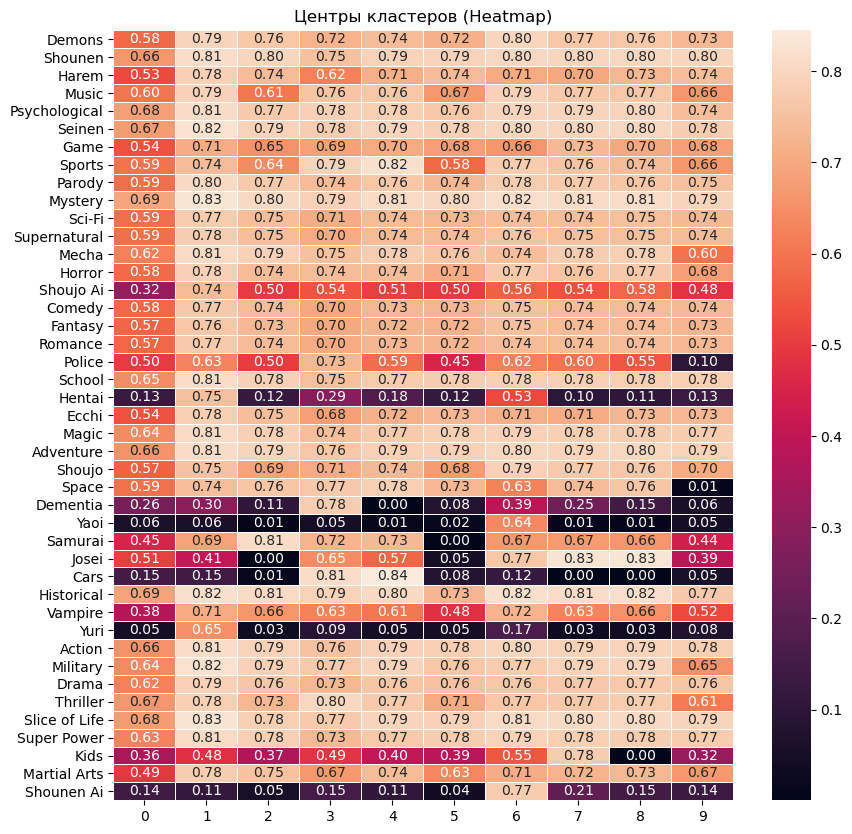

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=user_anime_raitings_scaled.columns[:-1]).transpose()

plt.figure(figsize=(10, 10))
plt.title('Центры кластеров (Heatmap)')
sns.heatmap(cluster_centers, annot=True, fmt=".2f", linewidths=0.5)
plt.xticks(rotation=0)
plt.show()

# Как выбрать нужное число кластеров

Такие методы как KMeans, Spectral clustering, Ward hierarchical clustering, Agglomerative clustering требуют количество кластеров как параметр. Это так называемый гипер-параметр, и его должен подбирать человек. Но на что человеку опираться при выборе? На некоторый функционал "качества"!

Вспомним идею кластеризации:
- минимизация внутрикластерного расстояния
- максимизация межкластерного расстояния

Другими словами - кучки кучнее и дальше друг от друга.

Логично, что мы хотим, чтобы точки распологались кучно возле центров своих кластеров. Но вот незадача: минимум такого функционала будет достигаться тогда, когда кластеров столько же, сколько и точек (то есть каждая точка – это кластер из одного элемента). Для решения этого вопроса (выбора числа кластеров) часто пользуются такой эвристикой: выбирают то число кластеров, начиная с которого описанный функционал $ J(C) $ падает "уже не так быстро". Или более формально: $$ D(k) = \frac{|J(C_k) - J(C_{k+1})|}{|J(C_{k-1}) - J(C_k)|}  \rightarrow \min\limits_k $$

Где, в случае kMeans $$ J(C) = \sum_{k=1}^K\sum_{i~\in~C_k} ||x_i - \mu_k|| \rightarrow \min\limits_C,$$ - сумма квадратов расстояний от точек до центроидов кластеров, к которым они относятся

#### Эта ячейка может выполнятся долго!

  0%|          | 0/29 [00:00<?, ?it/s]C:\Users\User\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
  3%|▎         | 1/29 [00:00<00:07,  3.57it/s]C:\Users\User\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
  7%|▋         | 2/29 [00:00<00:08,  3.09it/s]C:\Users\User\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 10%|█         | 3/29 [00:01<00:10,  2.59it/s]C:\Users\User\AppData\Roaming\Python\Python39\site-packages\sklea

Text(0, 0.5, '$J(C_k)$')

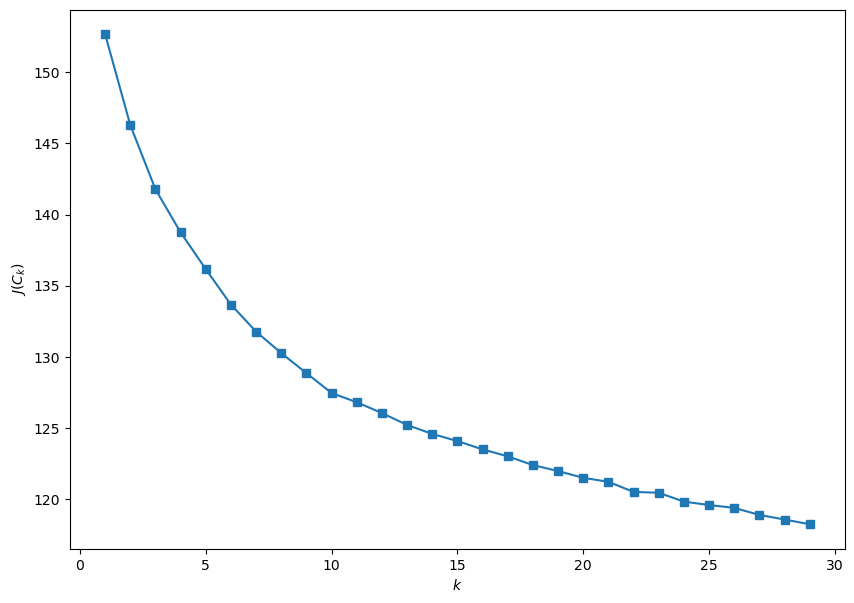

In [33]:
inertia = []
N = 30
for k in tqdm(range(1, N)):
    kmeans = KMeans(n_clusters=k).fit(scaler.fit_transform(user_anime_raitings_scaled))
    inertia.append(np.sqrt(kmeans.inertia_))
plt.figure(figsize=(10,7))
plt.plot(range(1, N), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$')

## Коэффициент силуэта

Данный коэффициент не предполагает знания истинных меток объектов, и позволяет оценить качество кластеризации, используя только саму (неразмеченную) выборку и результат кластеризации.

Сначала силуэт определяется отдельно для каждого объекта. Обозначим через $a$ - среднее расстояние от данного объекта до объектов из того же кластера, через $b$ - среднее расстояние от данного объекта до объектов из ближайшего кластера (отличного от того, в котором лежит сам объект). Тогда силуэтом данного объекта называется величина: $$s = \frac{b - a}{\max(a, b)}.$$ Силуэтом выборки называется средняя величина силуэта объектов данной выборки. Таким образом, силуэт показывает, насколько среднее расстояние до объектов своего кластера отличается от среднего расстояния до объектов других кластеров. Данная величина лежит в диапазоне $[-1, 1]$. Значения, близкие к -1, соответствуют плохим (разрозненным) кластеризациям, значения, близкие к нулю, говорят о том, что кластеры пересекаются и накладываются друг на друга, значения, близкие к 1, соответствуют "плотным" четко выделенным кластерам. Таким образом, чем больше силуэт, тем более четко выделены кластеры, и они представляют собой компактные, плотно сгруппированные облака точек.

С помощью силуэта можно выбирать оптимальное число кластеров $k$ (если оно заранее неизвестно) - выбирается число кластеров, максимизирующее значение силуэта. В отличие от предыдущих метрик, силуэт зависит от формы кластеров, и достигает больших значений на более выпуклых кластерах, получаемых с помощью алгоритмов, основанных на восстановлении плотности распределения.

#### Эта ячейка может выполняться долго!

In [34]:
from sklearn.metrics import silhouette_score, silhouette_samples

def draw_sil_score(X, range_n_clusters=[2, 3, 4, 5, 6, 10, 12, 13, 20]):
    scores = []
    for n_clusters in tqdm(range_n_clusters):
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)
        silhouette_avg = silhouette_score(X, cluster_labels)
        scores.append(silhouette_avg)
    plt.plot(range_n_clusters, scores)
    return range_n_clusters[np.argmax(scores)]

  0%|          | 0/28 [00:00<?, ?it/s]C:\Users\User\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
  4%|▎         | 1/28 [00:01<00:46,  1.71s/it]C:\Users\User\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
  7%|▋         | 2/28 [00:03<00:44,  1.73s/it]C:\Users\User\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 11%|█         | 3/28 [00:04<00:40,  1.61s/it]C:\Users\User\AppData\Roaming\Python\Python39\site-packages\sklea

2

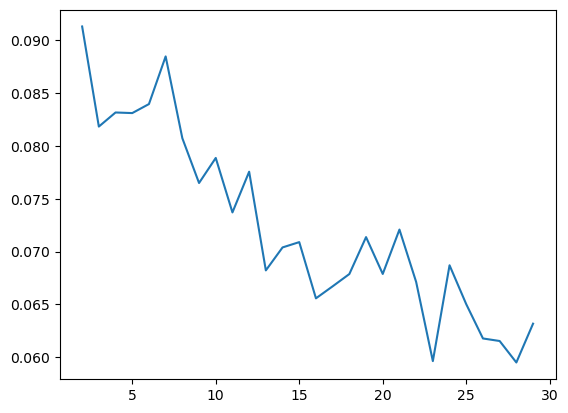

In [35]:
draw_sil_score(scaler.fit_transform(user_anime_raitings_scaled), range(2, 30))

### 17. Выберите количество кластеров `k` по методам выше. Натренируйте kMeans и снова нарисуйте heatmap.

C:\Users\User\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


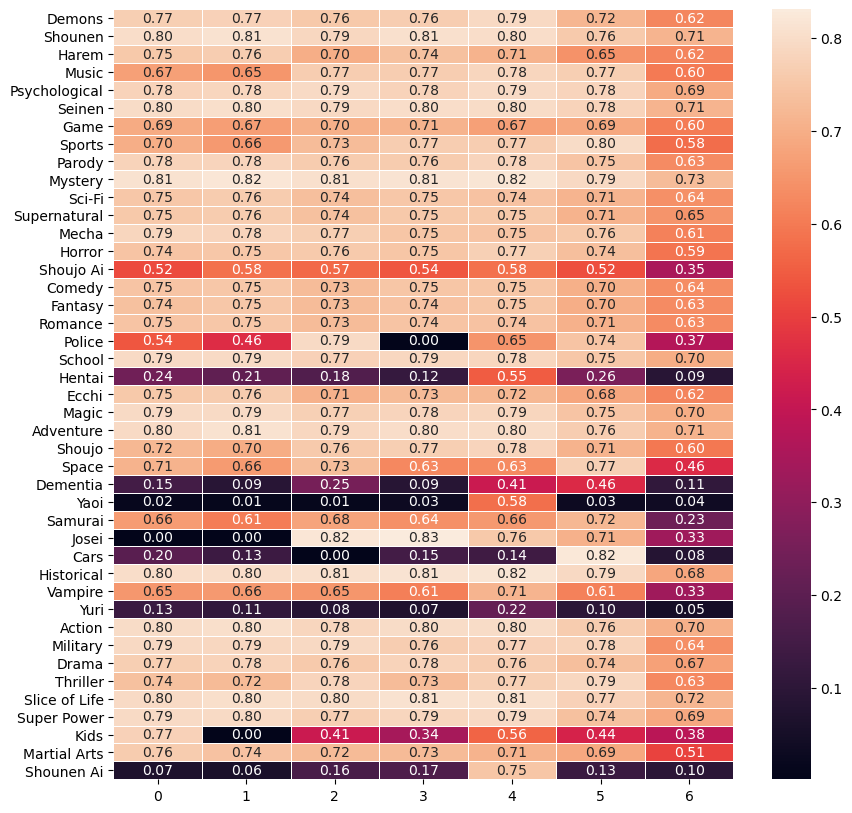

In [36]:
from sklearn.cluster import KMeans

user_anime_raitings_scaled.drop(columns=['cluster'], inplace=True)
kmeans = KMeans(n_clusters=7, random_state=0)
clusters = kmeans.fit_predict(user_anime_raitings_scaled)
user_anime_raitings_scaled['cluster'] = clusters

cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=user_anime_raitings_scaled.columns[:-1]).transpose()

plt.figure(figsize=(10, 10))
sns.heatmap(cluster_centers, annot=True, fmt=".2f", linewidths=0.5)
plt.xticks(rotation=0)
plt.show()

### 18. Порекомендуйте что-нибудь абстрактному пользователю.
Это можно сделать разными способами. Как это сделать подумайте сами.

Возможные варианты решения:
 * в каждом кластере отсортировать жанры по тому, насколько жанр важен.
 * взять каждый кластер -> получить все аниме, которые смотрят в этом кластере -> отсортировать по рейтину.



In [37]:
sorted_genres_by_cluster = {}
cluster_centers_by_genre = cluster_centers.transpose()

for cluster in range(len(cluster_centers_by_genre)):
    cluster_center = cluster_centers_by_genre.iloc[cluster]  
    sorted_genre_indices = cluster_center.argsort()[::-1]  
    sorted_genres = cluster_centers_by_genre.columns[sorted_genre_indices] 
    sorted_genres_by_cluster[cluster] = sorted_genres


for i in sorted_genres_by_cluster:
    print(f'Кластер {i+1}: ',', '.join(list(sorted_genres_by_cluster[i])[:10]))


Кластер 1:  Mystery, Shounen, Historical, Seinen, Action, Slice of Life, Adventure, Magic, Super Power, School
Кластер 2:  Mystery, Shounen, Adventure, Seinen, Action, Slice of Life, Historical, Super Power, Magic, School
Кластер 3:  Josei, Historical, Mystery, Slice of Life, Psychological, Police, Military, Seinen, Shounen, Adventure
Кластер 4:  Josei, Historical, Mystery, Slice of Life, Shounen, Adventure, Seinen, Action, School, Super Power
Кластер 5:  Historical, Mystery, Slice of Life, Shounen, Adventure, Action, Seinen, Psychological, Demons, Super Power
Кластер 6:  Cars, Sports, Historical, Mystery, Thriller, Psychological, Seinen, Military, Slice of Life, Space
Кластер 7:  Mystery, Slice of Life, Shounen, Seinen, Adventure, Action, School, Magic, Psychological, Super Power
